In [1]:
import dicom
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import glob
import pickle

%matplotlib inline

In [92]:
nodule_files = glob.glob('./data/kaggle/*.pickle')
for nodule_file in nodule_files:
    with open(nodule_file, "rb") as f:
        tmp = pickle.load(f, encoding='latin1')
        print(len(tmp[2]))

print(len(tmp[2]))

200
200
200
200
200
397
397


In [2]:
nodule_files = glob.glob('./data/kaggle/*.pickle')
with open(nodule_files[0], "rb") as f:
    data = pickle.load(f, encoding='latin1')

for nodule_file in nodule_files[1:]:
    with open("./data/kaggle/nodules1.pickle", "rb") as f:
        tmp = pickle.load(f, encoding='latin1')
        data = np.hstack((data, tmp))
        
data = np.swapaxes(data, 0, 1)

In [3]:
num_patients = data.shape[0]
print("Number of patients:", num_patients)

Number of patients: 1200


Patient ID: 0c9d8314f9c69840e25febabb1229fa4
Patient label: 0
Number of nodules detected for patient: 30


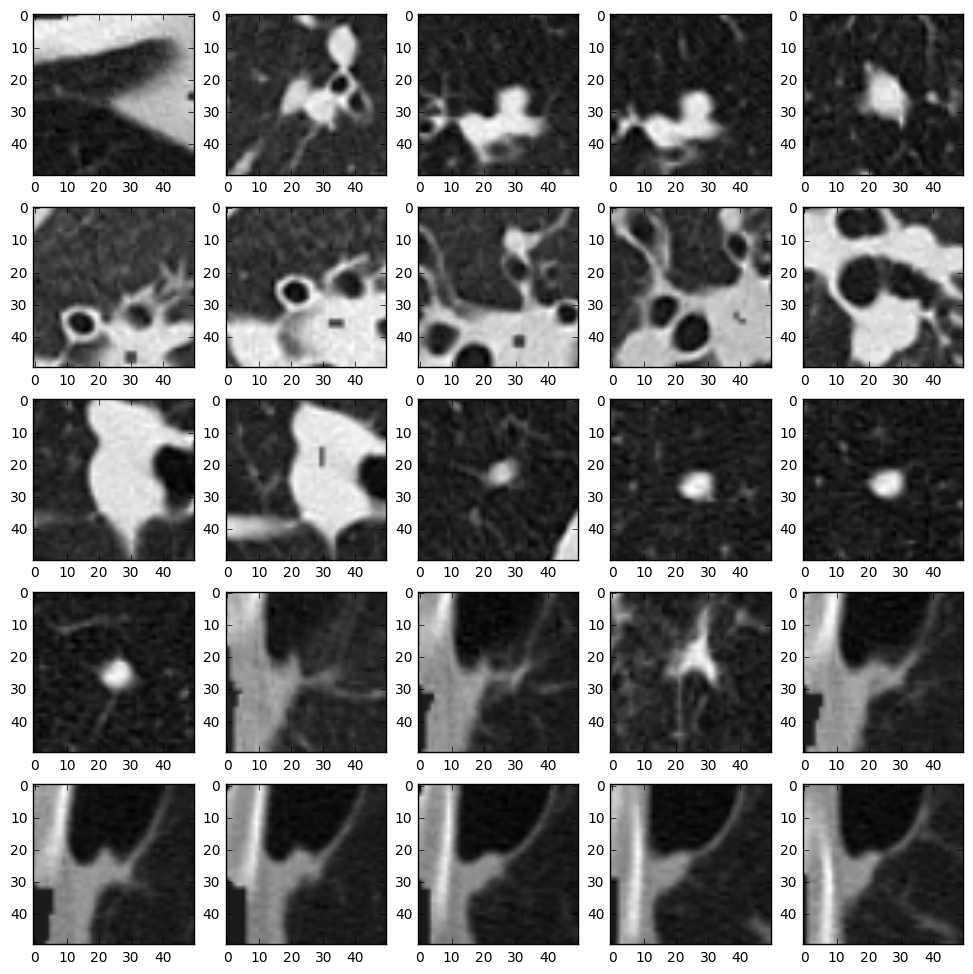

In [4]:
# Detected nodules for non-cancerous patient

print("Patient ID:", path.split(data[0][1])[1])
print("Patient label:", data[0][2])
print("Number of nodules detected for patient:", len(data[0][0]))

fig, ax = plt.subplots(5, 5,figsize=(12, 12))
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(data[0][0][i * 5 + j], cmap='gray')

Patient ID: f29d00ddf6d9846aa600c3f0edf5f952
Patient label: 1
Number of nodules detected for patient: 57


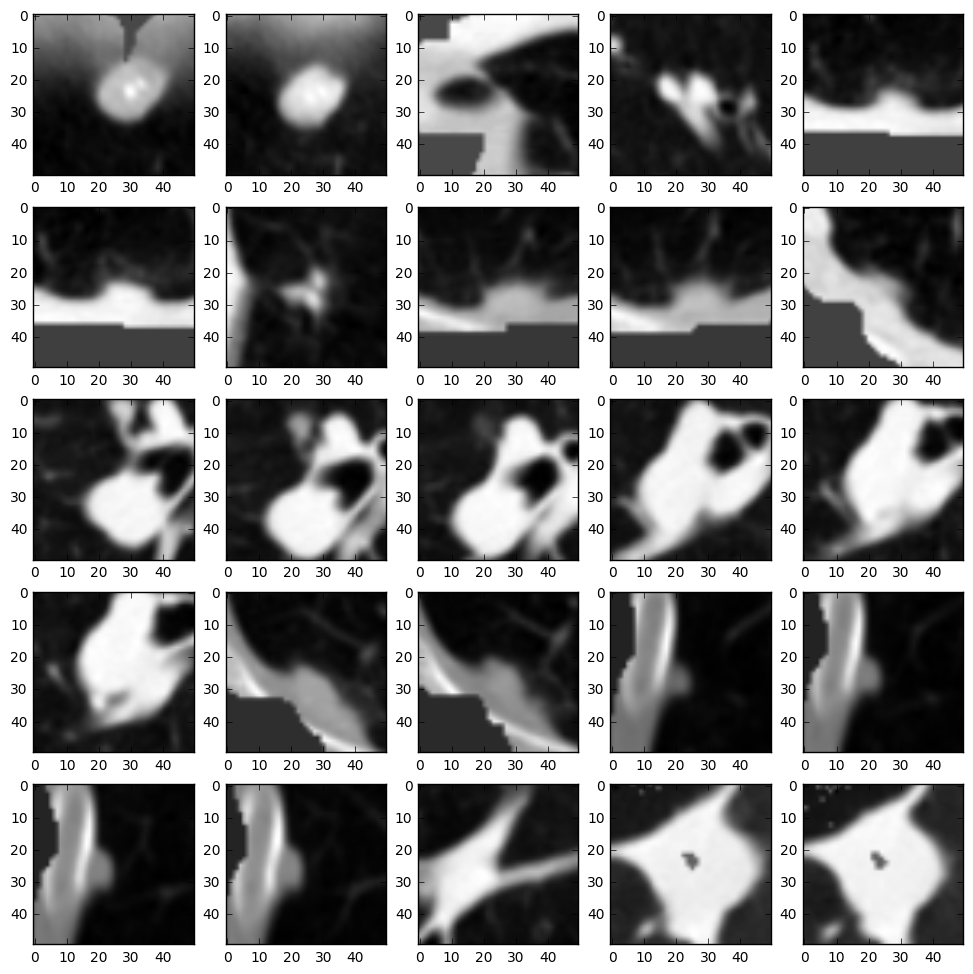

In [5]:
# Detected nodules for non-cancerous patient

print("Patient ID:", path.split(data[12][1])[1])
print("Patient label:", data[12][2])
print("Number of nodules detected for patient:", len(data[12][0]))

fig, ax = plt.subplots(5, 5,figsize=(12, 12))
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(data[12][0][i * 5 + j], cmap='gray')

In [55]:
# Prepare data for training
nodules = data[0][0]
labels = np.ones(data[0][0].shape[0]) * data[0][2]
for idx, patient in enumerate(data[1:]):
    if patient[0].any():
        labels = np.concatenate((labels, np.ones(patient[0].shape[0]) * patient[2]))
        nodules = np.vstack((nodules, patient[0]))

In [82]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

num_classes = 2
num_samples = nodules.shape[0]
img_rows = nodules.shape[1]
img_cols = nodules.shape[2]

X_train, X_test, y_train, y_test = train_test_split(nodules, labels, test_size=0.33, random_state=42)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)


y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

batch_size = 128
epochs = 10

model = Sequential()
model.add(Conv2D(32, 3, 3,
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs,
          verbose=1, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/home/olivier/anaconda3/lib/python3.5/site-packages/keras/utils/np_utils.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


Train on 16203 samples, validate on 7981 samples
Epoch 1/10
16203/16203 [==============================] - 117s - loss: 0.6322 - acc: 0.6606 - val_loss: 0.6174 - val_acc: 0.6671
Epoch 2/10
16203/16203 [==============================] - 116s - loss: 0.5866 - acc: 0.6888 - val_loss: 0.5655 - val_acc: 0.7107
Epoch 3/10
16203/16203 [==============================] - 107s - loss: 0.5334 - acc: 0.7334 - val_loss: 0.5064 - val_acc: 0.7534
Epoch 4/10
16203/16203 [==============================] - 110s - loss: 0.4591 - acc: 0.7828 - val_loss: 0.4492 - val_acc: 0.7949
Epoch 5/10
16203/16203 [==============================] - 109s - loss: 0.3827 - acc: 0.8342 - val_loss: 0.3773 - val_acc: 0.8443
Epoch 6/10
16203/16203 [==============================] - 110s - loss: 0.3157 - acc: 0.8695 - val_loss: 0.3645 - val_acc: 0.8455
Epoch 7/10
16203/16203 [==============================] - 107s - loss: 0.2558 - acc: 0.8971 - val_loss: 0.3059 - val_acc: 0.8806
Epoch 8/10
16203/16203 [========================

In [84]:
model.save_weights('./data/kaggle/convnet_nodules.h5')